In [ ]:
import numpy as np
print(np.__version__)
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import cProfile
import pstats

#constants
g = 9.81 #m/s2
temp = 20 + 273.15 #reaction temperatures, K
R = 8.314472*1000 #gas constant, m3.Pa/(kmol.K)
Mw_KOH = 56.1056 #g/mol

# Parameters for PDE
L = 0.395               # Length of the column (m)
N = 40             # Number of grid
dz = L / (N - 1)        # Spatial step (m)
dt = 0.1             # Time step (s)
T_max = 36000        # Total simulation time (s)
num_time_steps = int(T_max / dt)

#Paramters of the bubble column
dc = 0.0254 #m (column diameter = 1 inch)
Ac = np.pi * ((dc / 2)**2) #cross sectional area, m2
Vc = Ac * L #unit: m3 (volume of liquid = volume of column)

#Parameter of solvent
KOH_wt = 0.2 #KOH concentration, in weight fraction, i.e: KOH_wt = 0.1 = 10%

#Parameter of incoming flue gas
Qg = 250 #ml/min
Qg = Qg / (60 * (10**6)) #m3/sec
ug = Qg / Ac #feed gas superficial velocity, m/s
mu_g = 17.82 * (10**-6) #Pa.s, viscosity of N2 gas at 25 deg C, 1 atm
rho_g = 1.25 #kg/m3. This is N2 density, for rough approximation
CO2g_flue = 0.05 #volume fraction = mole fraction of CO2 in the incoming flue gas
Q_CO2 = CO2g_flue * Qg
C_CO2_flue = CO2g_flue / 24   # Concentration of CO2 in gas phase (kmol/m^3)

print(Vc)
print(C_CO2_flue)
print(ug)
print(dz)

In [ ]:
#KOH solution - density and viscsity
# Corrected data: KOH concentration in mol/L, corresponding wt%, density (g/cm³), and viscosity (mPa.s)
data_koh = {
    1.018: (5.457, 1.046520, 0.9980),  
    2.003: (10.302, 1.091221, 1.1200),
    3.000: (14.840, 1.134401, 1.2656),
    4.000: (19.087, 1.175736, 1.4388),
    5.003: (23.095, 1.215362, 1.6594),
    6.060: (27.092, 1.255184, 1.8760),
    6.921: (30.237, 1.284401, 2.2339),
    7.997: (35.118, 1.326461, 2.5355),
    9.000: (37.066, 1.362377, 2.9927),
    9.987: (39.116, 1.395491, 3.5557),
    10.981: (41.318, 1.429033, 4.2830),
    12.121: (46.507, 1.462389, 5.5439),
    13.138: (49.189, 1.498592, 6.7003),
    14.152: (51.861, 1.531086, 8.5452)
}

# Extract molarities, wt%, densities, and viscosities
molarities = np.array(list(data_koh.keys()))  # mol/L
wt_percentages = np.array([value[0] for value in data_koh.values()])  # wt%
densities = np.array([value[1] for value in data_koh.values()])  # g/cm³
viscosities_mPa_s = np.array([value[2] for value in data_koh.values()])  # mPa.s

# Convert viscosities from mPa.s to Pa.s
viscosities_Pa_s = viscosities_mPa_s * 1e-3

# Create interpolation functions for molarity, density, and viscosity based on wt%
molarity_interpolator = interp1d(wt_percentages, molarities, kind='linear', fill_value='extrapolate')
density_interpolator = interp1d(wt_percentages, densities, kind='linear', fill_value='extrapolate')
viscosity_interpolator = interp1d(wt_percentages, viscosities_Pa_s, kind='linear', fill_value='extrapolate')

# Function to get molarity
def get_molarity(wt_percentage):
    return molarity_interpolator(wt_percentage)

# Function to get density
def get_density(wt_percentage):
    return density_interpolator(wt_percentage)

# Function to get viscosity
def get_viscosity(wt_percentage):
    return viscosity_interpolator(wt_percentage)

In [ ]:
#KOH solution - surface tension function

# Given data: KOH solution density (g/cm³) and surface tension (dynes/cm)
data_surface_tension = {
    1.0479: 75.1,
    1.0480: 75.1,
    1.0484: 74.9,
    1.0943: 78.5,
    1.0947: 78.5,
    1.0953: 78.7,
    1.1388: 81.7,
    1.1763: 84.2,
    1.2092: 86.4,
    1.2433: 88.9,
    1.2488: 89.2,
    1.2480: 88.9,
    1.2735: 91.4,
    1.2989: 93.4,
    1.3015: 93.8,
    1.3023: 93.9,
    1.3515: 97.6
}

# Convert density and surface tension data to arrays
densities = np.array(list(data_surface_tension.keys()))  # g/cm³
surface_tensions_dynes_per_cm = np.array(list(data_surface_tension.values()))  # dynes/cm

# Convert surface tension from dynes/cm to N/m (1 dyne/cm = 0.001 N/m)
surface_tensions_N_per_m = surface_tensions_dynes_per_cm * 0.001

# Create an interpolation function for surface tension
surface_tension_interpolator = interp1d(densities, surface_tensions_N_per_m, kind='linear', fill_value='extrapolate')

# Function to get surface tension
def get_surface_tension(density):
    return surface_tension_interpolator(density)

In [ ]:
def solvent_parameters(KOH_wt): #solvent parameters
    if KOH_wt > 1e-3:
        rho_l = get_density(KOH_wt*100) * 1000 #kg/m3
        mu_l = get_viscosity(KOH_wt*100) #Pa.s
        sigma_l = get_surface_tension(rho_l/1000) #N/m
        KOH_conc = get_molarity(KOH_wt*100) #mol/L or kmol/m3
    else: #water
        rho_l = 1000 #kg/m3
        mu_l = 1e-3 #Pa.s
        sigma_l = 72e-3 #N/m
        KOH_conc = 0
    return rho_l, mu_l, sigma_l, KOH_conc

In [ ]:
rho_l, mu_l, sigma_l, KOH_conc = solvent_parameters(KOH_wt)
print(rho_l)
print(mu_l)
print(sigma_l)
print(KOH_conc)

In [ ]:
#calculating interfacial area
#calculate bubble size diameter first. Assume bubble size stays constant

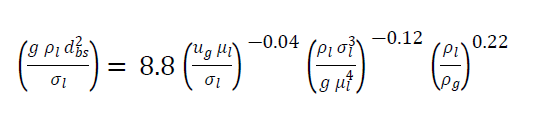

In [ ]:
dbs = 8.8 * ((ug * mu_l / sigma_l)**-0.04) * ((rho_l * (sigma_l**3) / (g * (mu_l**4)))**-0.12) * ((rho_l/rho_g)**0.22) * sigma_l / (g * rho_l)
dbs = dbs**0.5 #bubble size diameter, m
print(dbs)

In [ ]:
#interfacial area, method 1
a1 = np.pi * ((dbs/2)**2)
print(a1)

In [ ]:
#interfacial area, method 2
a2 = 4 * np.pi * ((dbs/2)**2)
print(a2)

In [ ]:
#gas holdup

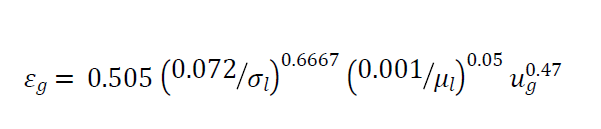

In [ ]:
def gas_holdup(sigma_l, mu_l, ug):
    epsilon_g = 0.505 * ((0.072/sigma_l)**0.6667) * ((0.001/mu_l)**0.05) * (ug**0.47)
    return epsilon_g
    
epsilon_g = gas_holdup(sigma_l, mu_l, ug)
print(epsilon_g)

In [ ]:
#interfacial area method 3

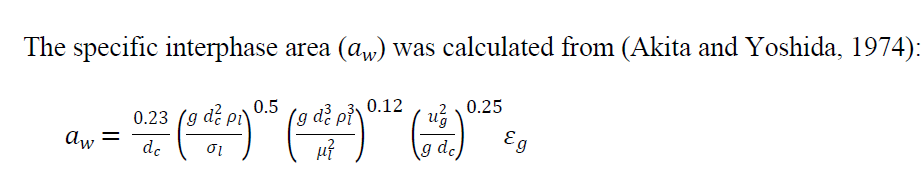

In [ ]:
a3 = (0.23/dc) * ((g * (dc**2) * rho_l / sigma_l)**0.5) * ((g * (dc**3) * (rho_l**3) / (mu_l**2))**0.12) * ((ug**2/(g*dc))**0.25) * epsilon_g
print(a3)

In [ ]:
#Henry's constant

def Henry_constant(R, temp, KOH_conc, C_OH, C_HCO3, C_CO3, C_CO2_g):
    Hw = 3.59 * (10**-7) * R * temp * np.exp(2044/temp) #CO2 solubility in pure water
    #sum_hi_ci = (0.1171 + 0.756 + 0.1372 + 0.1666 - 0.0183) * NaOH_conc
    sum_hi_ci = 0.0922* KOH_conc + 0.756 * C_OH + 0.1372 * C_HCO3 + 0.1666 * C_CO3 - 0.0183 * C_CO2_g 
    H = Hw / (10**sum_hi_ci) #CO2 solubility in electrolyte
    return H

In [ ]:
def diffusivity(OH, temp):
    Dw = 2.35 * (10**-6) * np.exp(-2119/temp) #unit: m2/s, diffusivity of CO2 in water
    D_CO2 = Dw * (1 - (1.29 * (10**-4) * OH))
    return D_CO2

In [ ]:
#calculate mass transfer coefficient
def calculate_kl(rho_g, ug, dbs, mu_g, D, mu_l, rho_l):
    Re = rho_g * ug * dbs / mu_g
    Sc = mu_l / (rho_l * D)
    kl = (2 + 0.015 * (Re**0.89) * (Sc**0.7)) * D / dbs
    return kl

In [ ]:
# calculate rate constant of first reaction, forward (CO2 + OH- -> HCO3-).
def calculate_k11(temp,KOH_conc,C_OH,C_HCO3,C_CO3):
    k11_inf = 10**(11.895 - 2382/temp)
    I = 0.5 * (KOH_conc + C_OH + C_HCO3 + C_CO3*4) #ionic strength, changes over time
    k11 = k11_inf * (10**(0.221*I - 0.016 * I * I))
    return k11 #(m^3/kmol/s)

In [ ]:
# calculate rate constant of first reaction, backward (CO2 + OH- -> HCO3-)
def calculate_k12(temp,k11):
    K3 = np.exp((-12092.1 / temp) - (36.786 * np.log(temp)) + 235.482)
    Kw = 10 ** (-(5839.5 / temp + 22.4773 * np.log10(temp) - 61.2062))
    k12 = k11*Kw/K3 #unit: 1/s
    return k12

In [ ]:
D_OH = 5.27 * (10**-9) #diffusion coefficient for OH- (Cussler, EL (2009): Diffusion: Mass Transfer in Fluid Systems (3rd Edition))
#also in Lide, D.R. (2003), CRC Handbook of Chemistry and Physics (84th Edition)

In [ ]:
#calculate klaw

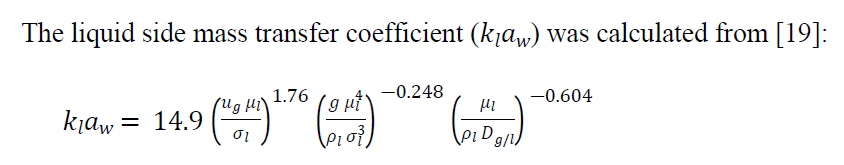

In [ ]:
def calculate_klaw(ug, mu_l, sigma_l, g, rho_l, D_CO2):
    kl_aw = 14.9 * ((ug * mu_l / sigma_l)**1.76) * ((g * (mu_l**4) / (rho_l * (sigma_l**3)))**-0.248) * ((mu_l / (rho_l * D_CO2))**-0.604)
    return kl_aw

In [ ]:
def calculate_enhancement_factor(C_OH, C_CO2_g, D_CO2, D_OH, H, k1_1, k_l):
    # Compute Hatta number
    Ha = np.sqrt(k1_1 * D_CO2 * C_OH) / k_l

    # Compute E_inf safely
    try:
        E_inf = (1 + (D_OH * C_OH) / (2 * D_CO2 * H * C_CO2_g)) * np.sqrt(D_CO2 / D_OH)
    except ZeroDivisionError:
        raise ValueError("ZeroDivisionError: Check if D_CO2, D_OH, H_safe, or C_CO2_gas_safe are zero or very small.")

    # Determine enhancement factor
    if np.isscalar(E_inf):  # Ensure it's scalar
        if E_inf > 1:
            term1 = -Ha**2 / (2 * (E_inf - 1))
            term2 = np.sqrt((Ha**4 / (4 * (E_inf - 1)**2)) + ((E_inf * Ha**2) / (E_inf - 1)) + 1)
            E = term1 + term2
        else:
            E = 1
    else:
        raise ValueError("E_inf is not a scalar. Ensure all inputs to calculate_enhancement_factor are scalar.")

    return E


In [ ]:
# Initialize concentrations
C_CO2_aq = np.full(N, 0.1) #1e-8
C_OH = np.full(N, KOH_conc)
C_HCO3 = np.full(N, C_CO2_aq/100)
C_CO3 = np.full(N, C_CO2_aq/100)
C_CO2_g = np.full(N, 1e-8)
C_CO2_g[0] = C_CO2_flue    # Set inlet concentration

# print(C_CO2_aq)
# print(C_OH)
# print(C_HCO3)

In [ ]:
a = 1 #a is correction value, to be regressed in the regression

In [ ]:
import csv

# Open the CSV file for writing
log_file = open("reaction_rates_log_rev2.csv", "w", newline="")
csv_writer = csv.writer(log_file)

# Write the header row
csv_writer.writerow(["Time", "z", 
                     "C_CO2_aq", "C_CO2_g", "C_OH", "C_HCO3", "C_CO3",
                     "dC_CO2_aq", "dC_CO2_g", "dC_OH", "dC_HCO3", "dC_CO3",
                     "k1_1", "k1_2"])

In [ ]:
# Define reaction terms and parameters
def calculate_parameters(R, temp, KOH_conc, C_OH, C_HCO3, C_CO3, C_CO2_g, 
                         rho_g, ug, dbs, mu_g, D_OH, mu_l, sigma_l, g, rho_l, Mw_KOH, tol=1e-4, max_iter=1000):
    
    # Calculate dynamic parameters
    k1_1 = calculate_k11(temp, KOH_conc, C_OH, C_HCO3, C_CO3)
    k1_2 = calculate_k12(temp, k1_1)
    
    k2_1 = 1e6
    log_K2_inf = 1568.94/temp + 0.4134 - 0.00673*temp
    log_K2 = log_K2_inf + (1.01 * (KOH_conc**0.5) / (1 + 1.27 * (KOH_conc**0.5))) + (0.125 * (KOH_conc**0.5))
    K2 = 10**log_K2  # m3/kmol
    k2_2 = k2_1 / K2  # Backward reaction rate for CO3^(2-) -> HCO3- + OH- (1/s)
    
    H = Henry_constant(R, temp, KOH_conc, C_OH, C_HCO3, C_CO3, C_CO2_g)
    D_CO2 = diffusivity(C_OH, temp)
    
    # Iterative process to solve for rho_l and KOH_wt consistency
    iteration = 0
    rho_l_old = rho_l  # Initial guess
    while iteration < max_iter:
        KOH_wt = C_OH * Mw_KOH / rho_l_old  # Using previous rho_l to calculate KOH_wt
        rho_l_new, mu_l, sigma_l, KOH_conc = solvent_parameters(KOH_wt)  # Update rho_l based on KOH_wt
        
        if abs(rho_l_new - rho_l_old) < tol:  # Convergence check
            break
        
        rho_l_old = rho_l_new  # Update rho_l for the next iteration
        iteration += 1

    if iteration == max_iter:
        print("Warning: Iterative process for rho_l did not converge within max iterations.")

    # Use the converged values
    rho_l = rho_l_new

    epsilon_g = gas_holdup(sigma_l, mu_l, ug)
    kl = calculate_kl(rho_g, ug, dbs, mu_g, D_CO2, mu_l, rho_l)
    kl_aw = calculate_klaw(ug, mu_l, sigma_l, g, rho_l, D_CO2)
    E = calculate_enhancement_factor(C_OH, C_CO2_g, D_CO2, D_OH, H, k1_1, kl)
    
    return k1_1, k1_2, k2_1, k2_2, H, D_CO2, epsilon_g, kl, kl_aw, E, rho_l, KOH_wt


# Declare the steady state flag globally
# steady_state_flag = False
mass_trf_sol = []

def reaction_rates(t, y, rho_l):
    #global steady_state_flag  # Access and modify the global variable
    global mass_trf_sol
    
    C_CO2_aq = y[:N]
    C_CO2_g = y[N:2 * N]
    C_OH = y[2 * N:3 * N]
    C_HCO3 = y[3 * N:4 * N]  
    C_CO3 = y[4 * N:]

    dC_CO2_aq = np.zeros(N)
    dC_CO2_g = np.zeros(N)
    dC_OH = np.zeros(N)
    dC_HCO3 = np.zeros(N)
    dC_CO3 = np.zeros(N)

    current_mass_trf = np.zeros(N)
    
    # Enforce constant inlet concentration
    C_CO2_g[0] = C_CO2_flue
    
    for z in range(1, N - 1):
        k1_1, k1_2, k2_1, k2_2, H, D_CO2, epsilon_g, kl, kl_aw, E, rho_l, KOH_wt = calculate_parameters(
            R, temp, KOH_conc, C_OH[z], C_HCO3[z], C_CO3[z], C_CO2_g[z], rho_g, ug, dbs, mu_g, D_OH, mu_l, sigma_l, g, rho_l, Mw_KOH)

        
        # Reaction terms
        R1_f = k1_1 * C_CO2_aq[z] * C_OH[z]
        R1_b = k1_2 * C_HCO3[z]
        R2_f = k2_1 * C_HCO3[z] * C_OH[z]  # Forward rate for second reaction
        R2_b = k2_2 * C_CO3[z]  # Backward rate for second reaction

        # Source terms
        S_CO2_aq = -R1_f + R1_b
        S_OH = -R1_f - R2_f + R1_b  + R2_b
        #print(f"dC_OH[{z}] before update: {dC_OH[z]}")  # Log before the update
        S_HCO3 = R1_f - R2_f - R1_b  + R2_b
        S_CO3 = R2_f - R2_b
        
        # Differential equations
        mass_trf = a * E * kl_aw * (C_CO2_g[z] * H - C_CO2_aq[z]) 
        if mass_trf < 1e-8:  # A very small threshold
            mass_trf = 0

        # Store mass_trf for the current spatial index
        current_mass_trf[z] = mass_trf
        
        # Apply constraint for max C_CO2_aq
        max_C_CO2_aq = C_CO2_g[z] * H  # Maximum allowable value

        # print(f"t={t:.2f}, z={z}, mass_trf={mass_trf:.5e}")

        dC_CO2_aq[z] = S_CO2_aq *(1-epsilon_g) + mass_trf  #+ (1-epsilon_g)*Dl * (C_CO2_aq[z + 1] - 2 * C_CO2_aq[z] + C_CO2_aq[z - 1]) / dz**2 
        dC_CO2_g[z] = -ug * (C_CO2_g[z] - C_CO2_g[z - 1]) / dz - mass_trf #+ epsilon_g * Dg * (C_CO2_aq[z + 1] - 2 * C_CO2_aq[z] + C_CO2_aq[z - 1]) / dz**2

        dC_OH[z] = S_OH*(1-epsilon_g)
        #print(f"dC_OH[{z}] after update: {dC_OH[z]}")   # Log after the update
        dC_HCO3[z] = S_HCO3*(1-epsilon_g)
        dC_CO3[z] = S_CO3*(1-epsilon_g)

        # Log data for the current z and time
        #csv_writer.writerow([t, z, 
        #                     C_CO2_aq[z], C_CO2_g[z], C_OH[z], C_HCO3[z], C_CO3[z],
        #                     dC_CO2_aq[z], dC_CO2_g[z], dC_OH[z], dC_HCO3[z], dC_CO3[z],
        #                     k1_1, k1_2])       
    # Boundary conditions

    #print(f"Before boundary (scipy) - C_CO2_g[-1]: {C_CO2_g[-1]}, C_CO2_g[-2]: {C_CO2_g[-2]}")
    C_CO2_g[-1] = C_CO2_g[-2]
    #print(f"After boundary (scipy) - C_CO2_g[-1]: {C_CO2_g[-1]}")

    #dC_CO2_g[-1] = -ug * (C_CO2_g[-1] - C_CO2_g[-2]) / dz  # Convective outflow at the outlet
    #dC_CO2_aq[0] = 0 #E * kl * 1 * (C_CO2_g[0]*H - C_CO2_aq[0])
    #dC_CO2_aq[-1] = dC_CO2_aq[-2]
    dC_CO2_aq[0] = 0  # Keep zero flux at the inlet
    C_CO2_aq[-1] = C_CO2_aq[-2]  # Outflow boundary at the outlet
    dC_OH[0] = dC_OH[-1] = 0
    dC_HCO3[0] = dC_HCO3[-1] = 0
    dC_CO3[0] = dC_CO3[-1] = 0


    # Append the current time step's mass_trf to the global list
    mass_trf_sol.append(current_mass_trf)
    
    return np.concatenate([dC_CO2_aq, dC_CO2_g, dC_OH, dC_HCO3, dC_CO3])


# Initial conditions
y0 = np.concatenate([C_CO2_aq, C_CO2_g, C_OH, C_HCO3, C_CO3])
#print("Initial y0 (scipy):", y0)



# Time integration
sol = solve_ivp(reaction_rates, [0, T_max], y0, method='BDF', rtol=1e-6, atol=1e-8, args=(rho_l,))
#sol = solve_ivp(reaction_rates, [0, T_max], y0, method='BDF', rtol=1e-8, atol=1e-10)
# print(f"Solver time step: {t:.4e}")

#close writing to csv file
log_file.close()

# Extract results
C_CO2_aq_sol = sol.y[:N, :]
C_CO2_g_sol = sol.y[N:2 * N, :]
C_OH_sol = sol.y[2 * N:3 * N, :]
C_HCO3_sol = sol.y[3 * N:4 * N, :]
C_CO3_sol = sol.y[4 * N:, :]
time_points = sol.t

# Convert mass_trf_sol to a NumPy array for easier manipulation
mass_trf_sol = np.array(mass_trf_sol)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("reaction_rates_log_rev2.csv")

# Choose the specific spatial point
z_point = 1  # Modify this if needed
df_z = df[df['z'] == z_point]

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

# Plot each species on a separate subplot
species = [
    ('dC_CO2_aq', 'dC_CO2_aq (kmol/m3/s)'),
    ('dC_CO2_g', 'dC_CO2_g (kmol/m3/s)'),
    ('dC_HCO3', 'dC_HCO3 (kmol/m3/s)'),
    ('dC_OH', 'dC_OH (kmol/m3/s)'),
    ('dC_CO3', 'dC_CO3 (kmol/m3/s)')
]

# Loop over species and axes
for i, (col, ylabel) in enumerate(species):
    row, col_idx = divmod(i, 3)  # Get row and column index
    ax = axes[row, col_idx]
    ax.plot(df_z['Time'], df_z[col], label=f'{col} at z={z_point}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

# Remove the last unused subplot if there is any
if len(species) < len(axes.flatten()):
    fig.delaxes(axes[1, 2])

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("reaction_rates_log_rev2.csv")

# Choose the specific spatial point (z)
z_point = 8 # Modify this if needed to inspect other spatial points
df_z = df[df['z'] == z_point]  # Filter data for the chosen z-point

# Create a figure with subplots: 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Adjust size as needed

# Define species and their labels for plotting
species = [
    ('C_CO2_aq', 'C_CO2_aq (kmol/m³)'),
    ('C_CO2_g', 'C_CO2_g (kmol/m³)'),
    ('C_HCO3', 'C_HCO3 (kmol/m³)'),
    ('C_OH', 'C_OH (kmol/m³)'),
    ('C_CO3', 'C_CO3 (kmol/m³)')
]

# Loop over species and map each to a subplot
for i, (col, ylabel) in enumerate(species):
    row, col_idx = divmod(i, 3)  # Determine row and column index
    ax = axes[row, col_idx]  # Select subplot
    ax.plot(df_z['Time'], df_z[col], label=f'{col} at z={z_point}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

    # Force the y-axis to use scientific notation without offset notation
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useOffset=False)

# If there are fewer than 6 subplots, delete the extra one
if len(species) < len(axes.flatten()):
    fig.delaxes(axes[1, 2])  # Remove the last unused subplot

# Adjust layout to avoid overlap and improve readability
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
# Log and plot reaction parameters and rates
time_points_to_plot = np.linspace(0, T_max, 100)

# Initialize storage for additional parameters
k1_1_values = []
k1_2_values = []
k2_1_values = []
k2_2_values = []
H_values = []
D_CO2_values = []
kl_values = []
kl_aw_values = []
E_values = []

# Loop over time points
for t in time_points_to_plot:
    idx = np.argmin(np.abs(sol.t - t))
    C_OH_at_t = C_OH_sol[:, idx]
    C_HCO3_at_t = C_HCO3_sol[:, idx]
    C_CO3_at_t = C_CO3_sol[:, idx]
    C_CO2_aq_at_t = C_CO2_aq_sol[:, idx]
    C_CO2_g_at_t = C_CO2_g_sol[:, idx]

    k1_1_values_t = []
    k1_2_values_t = []
    k2_1_values_t = []
    k2_2_values_t = []
    H_values_t = []
    D_CO2_values_t = []
    kl_values_t = []
    kl_aw_values_t = []
    E_values_t = []

    for z in range(N):
        # Calculate parameters for the given time and spatial point
        k1_1_at_z, k1_2_at_z, k2_1_at_z, k2_2_at_z, H, D_CO2, epsilon_g, kl, kl_aw, E, rho_l, NaOH_wt = calculate_parameters(
            R, temp, KOH_conc, C_OH[z], C_HCO3[z], C_CO3[z], C_CO2_g[z], rho_g, ug, dbs, mu_g, D_OH, mu_l, sigma_l, g, rho_l, Mw_KOH)

        # Append calculated values to their respective lists
        k1_1_values_t.append(k1_1_at_z)
        k1_2_values_t.append(k1_2_at_z)  # Fixed variable name
        k2_1_values_t.append(k2_1_at_z)
        k2_2_values_t.append(k2_2_at_z)
        H_values_t.append(H)
        D_CO2_values_t.append(D_CO2)
        kl_values_t.append(kl)
        kl_aw_values_t.append(kl_aw)
        E_values_t.append(E)


    # Store time-averaged values
    k1_1_values.append(np.mean(k1_1_values_t))
    k1_2_values.append(np.mean(k1_2_values_t))
    k2_1_values.append(np.mean(k2_1_values_t))
    k2_2_values.append(np.mean(k2_2_values_t))
    H_values.append(np.mean(H_values_t))
    D_CO2_values.append(np.mean(D_CO2_values_t))
    kl_values.append(np.mean(kl_values_t))
    kl_aw_values.append(np.mean(kl_aw_values_t))
    E_values.append(np.mean(E_values_t))

# Create subplots: 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# List of parameters to plot
parameters = [
    (time_points_to_plot, k1_1_values, "k1_1 (mean)", "k1_1"),
    (time_points_to_plot, k2_1_values, "k1_2 (mean)", "k1_2"),
    (time_points_to_plot, k2_1_values, "k2_1 (mean)", "k2_1"),
    (time_points_to_plot, k2_1_values, "k2_2 (mean)", "k2_2"),
    (time_points_to_plot, H_values, "H (mean)", "H"),
    (time_points_to_plot, D_CO2_values, "D_CO2 (mean)", "D_CO2"),
    (time_points_to_plot, kl_values, "kl (mean)", "kl"),
    (time_points_to_plot, kl_aw_values, "kl_aw (mean)", "kl_aw"),
    (time_points_to_plot, E_values, "E (mean)", "E"),
]

# Loop through each parameter and subplot
for i, (x, y, title, ylabel) in enumerate(parameters):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.plot(x, y, label=ylabel)
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid()

    # Enable scientific notation for y-axis
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the steady-state time
# Define the increase threshold to filter out the initial plateau
increase_threshold = 0.99 * C_CO2_g_sol[-1, -1]  # 1% of the final outlet concentration

# Find indices after the concentration starts increasing significantly
post_increase_idx = np.where(C_CO2_g_sol[-1, :] > increase_threshold)[0]

# Apply a running window gradient check to detect the first plateau
if len(post_increase_idx) > 0:
    # Extract the time and concentration for the relevant portion
    relevant_times = time_points[post_increase_idx]
    relevant_concentration = C_CO2_g_sol[-1, post_increase_idx]
    
    # Calculate the gradient (rate of change)
    gradients = np.gradient(relevant_concentration, relevant_times)
    
    # Find the first index where the gradient is consistently small (near-zero)
    steady_plateau_idx = np.where(np.abs(gradients) < 1e-5)[0]
    
    if len(steady_plateau_idx) > 0:
        # Use the first occurrence of a consistent plateau
        steady_state_idx = post_increase_idx[steady_plateau_idx[0]]
        steady_state_time = time_points[steady_state_idx]
        steady_state_concentration = C_CO2_g_sol[-1, steady_state_idx]
    else:
        steady_state_time = None
        steady_state_concentration = None
else:
    steady_state_time = None
    steady_state_concentration = None

# Calculate the breakthrough time
breakthrough_idx = np.where(C_CO2_g_sol[-1, :] > 4.2e-4)[0]  # breakthrough condition: 1% CO2 at outlet
breakthrough_time = time_points[breakthrough_idx[0]] if len(breakthrough_idx) > 0 else None

# Plot results
plt.plot(time_points, C_CO2_g_sol[-1, :], label='CO2 (g) at Column Outlet')
#plt.plot(time_points, C_CO2_g_sol[0, :], label='CO2 (g) at Column Inlet')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (kmol/m^3)')

# Annotate the steady-state and breakthrough times
if steady_state_time:
    plt.axvline(x=steady_state_time, color='g', linestyle='--', label=f'Steady State: {steady_state_time:.2f}s')
    plt.text(steady_state_time, steady_state_concentration, 
             f'{steady_state_concentration*24:.2f} vol fraction', 
             color='g', ha='left', va='bottom')
if breakthrough_time:
    plt.axvline(x=breakthrough_time, color='r', linestyle='--', label=f'Breakthrough Time: {breakthrough_time:.2f}s')

plt.legend()
plt.show()



In [ ]:
import pandas as pd

# Specify the file path
file_path = r"C:\Users\jvo_c\OneDrive\Documents\Research\DAC\ExperimentData_csv\Exp3_20KOH_250mlmin_5CO2.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it loaded correctly
print(data.head())


In [ ]:
t_minute = data['t_minute'].values
t_hour = data['t_hour'].values
CO2g_headspace = data['fraction_CO2'].values #fraction of CO2 in the headspace gas (fraction)

In [ ]:
# Convert fraction_CO2 to percentage
data['CO2g_percentage'] = data['fraction_CO2'] * 100  # Convert fraction to percentage

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['t_hour'], data['CO2g_percentage'], marker='o', linestyle='-', color='b', label='% CO2 in Headspace')

# Adding labels and title
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('% CO2 in Headspace', fontsize=12)
plt.title('CO2 Fraction in Headspace Over Time, 20 wt% KOH, Qg = 250 ml/min, 5% CO2(g) in the inlet', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)

# Show the plot
plt.show()


In [ ]:
# from scipy.optimize import differential_evolution
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the objective function for regression
# def objective_function(a):
#     global mass_trf_sol  # Use the global mass_trf_sol

#     # Reset `mass_trf_sol` to a list at the beginning of each optimization step
#     mass_trf_sol = []  
    
#     # Run the simulation with the current correction factor 'a'
#     sol = solve_ivp(
#         reaction_rates,
#         [0, T_max],
#         y0,
#         method='BDF',
#         rtol=1e-6,
#         atol=1e-8,
#         args=(rho_l, a)
#     )
    
#     # Extract simulated CO2 concentrations at the last spatial step for all time steps
#     C_CO2_g_simulated = sol.y[N:2 * N, :]  # Extract the last spatial step for all time steps

#     # Experimental Data
#     experimental_time = data['t_hour'].values * 3600  # Convert hours to seconds
#     experimental_CO2 = data['fraction_CO2'].values * 100  # Convert fraction to percentage

#     # Interpolate experimental CO2 to match simulation time points
#     simulated_time_points = sol.t
#     interpolated_experimental_CO2 = np.interp(simulated_time_points, experimental_time, experimental_CO2)

#     # Calculate the error (e.g., RMSE)
#     error = np.sqrt(np.mean((C_CO2_g_simulated - interpolated_experimental_CO2) ** 2))
#     return error

# # Run the optimization using Differential Evolution
# bounds = [(1e-15, 1e-1)]  # Bounds for 'a'
# result = differential_evolution(objective_function, bounds, strategy='best1bin', tol=1e-6)

# # Extract the optimized correction factor 'a'
# optimized_a = result.x[0]
# print(f"Optimized correction factor a: {optimized_a}")

# # Final Simulation with Optimized a
# mass_trf_sol = []  # Reset to list for the final simulation
# sol = solve_ivp(
#     reaction_rates,
#     [0, T_max],
#     y0,
#     method='BDF',
#     rtol=1e-6,
#     atol=1e-8,
#     args=(rho_l, optimized_a)
# )

# # Convert mass_trf_sol to NumPy array after all simulations
# mass_trf_sol = np.array(mass_trf_sol)

# # Extract final simulated results
# simulated_time = sol.t / 3600  # Convert to hours
# C_CO2_g_simulated = sol.y[N-1, :]  # Extract the last spatial step for all time steps

# # Plot experimental vs simulated results
# plt.figure(figsize=(10, 6))
# # Experimental Data
# plt.scatter(data['t_hour'], data['fraction_CO2'] * 100, label='Experimental Data', color='red')
# # Simulated Data
# plt.plot(simulated_time, C_CO2_g_simulated, label='Simulated Data', color='blue')
# plt.xlabel('Time (hours)')
# plt.ylabel('% CO2 in Headspace')
# plt.title('Experimental vs Simulated CO2 Concentration')
# plt.legend()
# plt.grid(True)
# plt.show()
